### DS 6040: Bayes Final Project
#### Project Title: Naive Bayes on Spam Emails
#### Team Members: Elizabeth Lee, Anahita Sharma

In [1]:
import pandas as pd
import numpy as np
import os
# from google.colab import files
import io
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
stopWords = set(stopwords.words('english'))

# ! apt install -qq enchant
# !pip install pyenchant
# import enchant 

# splits words up to stem 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import scipy.stats as st
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## UCI DATA

Column names for the csv file provided by the UCI dataset documentation

In [2]:
colnames_uci = ["word_freq_make","word_freq_address","word_freq_all","word_freq_3d","word_freq_our","word_freq_over","word_freq_remove","word_freq_internet",
                "word_freq_order","word_freq_mail","word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses",
                "word_freq_free",
"word_freq_business",
"word_freq_email",
"word_freq_you",
"word_freq_credit",
"word_freq_your",
"word_freq_font",
"word_freq_000",
"word_freq_money",
"word_freq_hp",
"word_freq_hpl",
"word_freq_george",
"word_freq_650",
"word_freq_lab",
"word_freq_labs",
"word_freq_telnet",
"word_freq_857",
"word_freq_data",
"word_freq_415",
"word_freq_85",
"word_freq_technology",
"word_freq_1999",
"word_freq_parts",
"word_freq_pm",
"word_freq_direct",
"word_freq_cs",
"word_freq_meeting",
"word_freq_original",
"word_freq_project",
"word_freq_re",
"word_freq_edu",
"word_freq_table",
"word_freq_conference",
"char_freq_;",
"char_freq_(",
"char_freq_[",
"char_freq_!",
"char_freq_$",
"char_freq_#",
"capital_run_length_average",
"capital_run_length_longest",
"capital_run_length_total","spam"]

Our analysis only focused on the vocabulary of the emails, not the properties of the words, and therefore the following columns were dropped.

In [3]:
to_drop = ["char_freq_;",
"char_freq_(",
"char_freq_[",
"char_freq_!",
"char_freq_$",
"char_freq_#",
"capital_run_length_average",
"capital_run_length_longest",
"capital_run_length_total"]

In [4]:
data_uci = pd.read_csv('spambase.data', header=None, names=colnames_uci)

In [5]:
data_uci = data_uci.drop(to_drop, axis=1) #spam = 1, ham = 0

In [6]:
# data cleaning
uci_spam_labels = data_uci['spam']
data_uci = data_uci.drop(['spam'], axis = 1)

In [7]:
data_uci[data_uci>0] = 1

In [8]:
data_uci.rename(columns=lambda x: x.split("_")[2], inplace=True)

In [9]:
data_uci['spamlabel'] = uci_spam_labels

In [10]:
counts = data_uci['spamlabel'].value_counts()
counts.index = ['Ham (0)', 'Spam (1)']

### EDA 

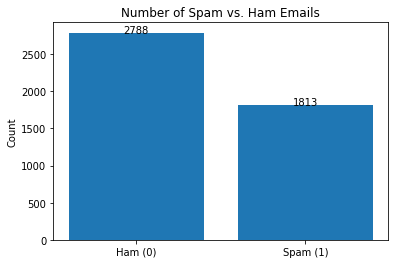

In [11]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')


plt.bar(counts.index, height = [counts[i] for i in counts.index])
plt.title("Number of Spam vs. Ham Emails")
plt.ylabel("Count")

addlabels(counts.index, [counts[i] for i in counts.index])

In [12]:
data_uci

#can split right off the bat (test train)

#then build naive bayes

#posterior distributions (uncertainty)

#bayesian logistic regression (look at forest plots to make other models)

#compare with WAIC

,make,address,all,3d,our,over,remove,internet,order,mail,...,direct,cs,meeting,original,project,re,edu,table,conference,spamlabel
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
4597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4598,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4599,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


## Naive Bayes

In [13]:
test_num = np.floor(len(data_uci) * 1/3)
test_num

1533.0

In [14]:
train_num = int(len(data_uci) - test_num)

In [15]:
train = data_uci.sample(train_num, replace = False, random_state = 601)
train

,make,address,all,3d,our,over,remove,internet,order,mail,...,direct,cs,meeting,original,project,re,edu,table,conference,spamlabel
1690,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1868,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2380,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2974,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4596,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4392,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1261,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
test = data_uci.drop(labels = train.index, inplace = False)
test

,make,address,all,3d,our,over,remove,internet,order,mail,...,direct,cs,meeting,original,project,re,edu,table,conference,spamlabel
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4595,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [17]:
spam_train = train[train['spamlabel'] == 1]
ham_train = train[train['spamlabel'] == 0]

spam_counts = spam_train.sum(axis = 0)
ham_counts = ham_train.sum(axis = 0)
df_train = pd.DataFrame({'Spam': spam_counts, 'Ham': ham_counts})[0: len(spam_counts) - 1]
df_train

,Spam,Ham
make,430.0,279.0
address,420.0,184.0
all,728.0,521.0
3d,24.0,6.0
our,751.0,415.0
over,454.0,211.0
remove,489.0,33.0
internet,401.0,145.0
order,372.0,151.0
mail,534.0,309.0


In [18]:
df_train['Spam'].sum()

12243.0

In [19]:
train_ham_num = len(train[train['spamlabel'] == 0])
train_spam_num = len(train[train['spamlabel'] == 1])
train_size = train_ham_num + train_spam_num
WordSums = [train_spam_num, train_ham_num]
WordSums

[1186, 1882]

In [20]:
prior_ham = train_ham_num / train_size
prior_spam = train_spam_num / train_size
priors = [prior_spam, prior_ham]
priors

[0.38657105606258146, 0.6134289439374185]

In [21]:
alpha = 1.5 # smoothing parameter
# df_train.sum(0)
v = len(df_train.index)

In [22]:
# probability of word given class
Pword = np.zeros([len(df_train.index), len(df_train.columns)])
for i in range(len(df_train.index)):
    for j in range(len(df_train.columns)):
        Pword[i,j] = (df_train.iloc[i,j] + alpha)/(WordSums[j] + v*alpha)
Pword = pd.DataFrame(Pword, index = df_train.index, columns = df_train.columns)
Pword

,Spam,Ham
make,0.343005,0.143552
address,0.335056,0.094933
all,0.579889,0.267400
3d,0.020270,0.003838
our,0.598172,0.213153
over,0.362083,0.108751
remove,0.389905,0.017656
internet,0.319952,0.074974
order,0.296900,0.078045
mail,0.425676,0.158905


In [23]:
test

,make,address,all,3d,our,over,remove,internet,order,mail,...,direct,cs,meeting,original,project,re,edu,table,conference,spamlabel
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4595,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [24]:
post_prob_df = test.copy()
post_prob_df['spam_posterior_probability'] = np.zeros([len(test.index), 1])
post_prob_df['ham_posterior_probability'] = np.zeros([len(test.index), 1])
post_prob_df

,make,address,all,3d,our,over,remove,internet,order,mail,...,meeting,original,project,re,edu,table,conference,spamlabel,spam_posterior_probability,ham_posterior_probability
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
4594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
4595,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
4597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0


In [25]:
email_words = np.array(test.apply(lambda x: x.index[x == 1].tolist(), axis = 1))

postprob_list = []

for w in email_words:

    WordsIndex = []
    
    for i in range(len(w)):
        for j in range(len(df_train.index)):
            if w[i] == df_train.index[j].strip():
                WordsIndex.append(j)
                
    likelihoods = np.ones(len(df_train.columns))
    for j in range(len(df_train.columns)):
        for i in WordsIndex:
            likelihoods[j] = likelihoods[j]*Pword.iloc[i][j]
            
    # Posterior Probabilities
    numerator = likelihoods * priors
    postprob = np.round(numerator/numerator.sum(), 4) # spam, ham
    
    postprob_list.append(postprob)

In [26]:
spam_post = [s[0] for s in postprob_list]

ham_post = [s[1] for s in postprob_list]


In [27]:
comp_df = pd.DataFrame({'spam_post':spam_post, 
              'ham_post':ham_post, 
              'actual':post_prob_df['spamlabel']})
comp_df

,spam_post,ham_post,actual
2,1.0000,0.0000,1
4,1.0000,0.0000,1
6,0.9996,0.0004,1
7,0.8830,0.1170,1
15,1.0000,0.0000,1
...,...,...,...
4593,0.1425,0.8575,0
4594,0.0224,0.9776,0
4595,0.7951,0.2049,0
4597,0.3633,0.6367,0


In [28]:
only_spam = comp_df[comp_df.actual == 1]
only_ham = comp_df[comp_df.actual == 0]

only_spam

,spam_post,ham_post,actual
2,1.0000,0.0000,1
4,1.0000,0.0000,1
6,0.9996,0.0004,1
7,0.8830,0.1170,1
15,1.0000,0.0000,1
...,...,...,...
1801,0.7012,0.2988,1
1802,0.9959,0.0041,1
1803,1.0000,0.0000,1
1808,0.9950,0.0050,1


Text(0.5, 1.0, 'P(Spam|W_N) for Ham Emails')

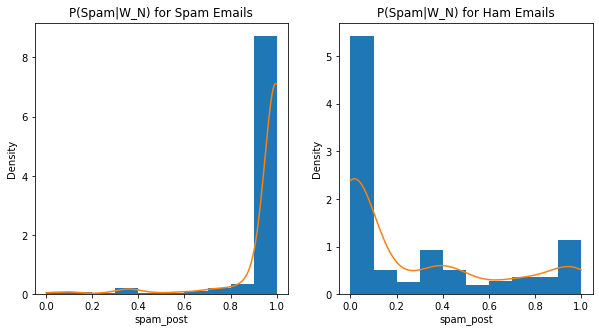

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(121)

plt.hist(only_spam['spam_post'], density=True)
sns.kdeplot(only_spam['spam_post'], clip=[0,1])

plt.title("P(Spam|W_N) for Spam Emails")

plt.subplot(122)

plt.hist(only_ham['spam_post'], density=True)
sns.kdeplot(only_ham['spam_post'], clip=[0,1])

plt.title("P(Spam|W_N) for Ham Emails")

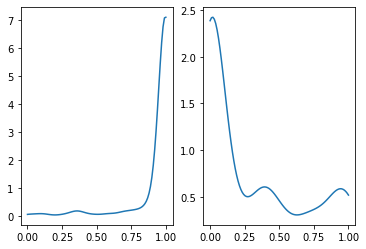

In [30]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

plt.subplot(121)

kde = gaussian_kde(only_spam['spam_post'])
dist_space = linspace(min(only_spam['spam_post']), max(only_spam['spam_post']), 100)

# plot the results
plt.plot( dist_space, kde(dist_space) )

plt.subplot(122)

kde = gaussian_kde(only_ham['spam_post'])
dist_space = linspace(min(only_ham['spam_post']), max(only_ham['spam_post']), 100)
plt.plot(dist_space, kde(dist_space) )

### Bayesian Logistic Regression

In [31]:
data_uci_freq = pd.read_csv('spambase.data', header=None, names=colnames_uci)
data_uci_freq

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [32]:
data_uci_freq = data_uci_freq.drop(to_drop, axis=1) #spam = 1, ham = 0

uci_spam_labels = data_uci_freq['spam']
data_uci_freq = data_uci_freq.drop(['spam'], axis = 1)

data_uci_freq.rename(columns=lambda x: x.split("_")[2], inplace=True)
data_uci_freq['spamlabel'] = uci_spam_labels
data_uci_freq

,make,address,all,3d,our,over,remove,internet,order,mail,...,direct,cs,meeting,original,project,re,edu,table,conference,spamlabel
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.0,0.0,0.12,0.00,0.06,0.06,0.0,0.0,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.31,0.31,0.31,0.0,0.0,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.0,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,1.20,0.0,0.0,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.32,0.00,0.32,0.0,0.0,0


### Model 1: All predictors/words
Assume the distribution for all words is Gaussian with mean 0, and a large SD to account for variation --> UNINFORMED PRIOR

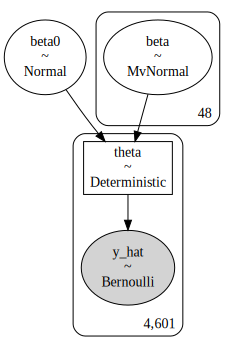

In [33]:
X = data_uci_freq[[c for c in data_uci_freq.columns if c != 'spamlabel']] 
y = data_uci_freq['spamlabel']
num_pred = len(X.columns)
with Model() as all_model:
    beta0 = pm.Normal('beta0', 0, sd = 1)
    beta = pm.MvNormal('beta', mu = np.zeros(num_pred), cov = np.identity(num_pred), shape = num_pred)
    
    mu = pm.invlogit(beta0 + pm.math.dot(X, beta))
    theta = pm.Deterministic('theta', mu)
    
    y_hat = pm.Bernoulli('y_hat', p = theta, observed = y)
pm.model_to_graphviz(all_model)

In [34]:
with all_model:
    all_trace = pm.sample(draws = 1000, cores = 4, chains = 2, tune = 1000)
    all_idata = az.from_pymc3(all_trace)
az.summary(all_idata, round_to = 2, var_names = ["beta0", "beta"])

<ipython-input-34-37ea084e5468>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  all_trace = pm.sample(draws = 1000, cores = 4, chains = 2, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 211 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-1.03,0.10,-1.22,-0.83,0.00,0.00,1243.22,1198.32,1.00
beta[0],-0.22,0.18,-0.55,0.13,0.00,0.00,1536.26,1168.46,1.00
beta[1],-0.17,0.06,-0.31,-0.07,0.00,0.00,2583.36,1440.71,1.00
beta[2],0.22,0.10,0.04,0.40,0.00,0.00,2695.70,1655.43,1.00
beta[3],1.24,0.60,0.21,2.35,0.01,0.01,1861.32,1264.18,1.00
beta[4],0.54,0.10,0.36,0.74,0.00,0.00,2104.74,1372.28,1.00
beta[5],0.93,0.21,0.55,1.32,0.01,0.00,1586.53,1246.05,1.00
beta[6],2.42,0.30,1.86,3.00,0.01,0.00,1980.56,1433.12,1.00
beta[7],0.67,0.17,0.37,1.00,0.00,0.00,2192.37,1397.57,1.00
beta[8],1.34,0.25,0.90,1.81,0.01,0.00,2007.79,1388.37,1.00


In [35]:
with all_model:
    waic_all = az.waic(all_trace)
waic_all

C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 4601 log-likelihood matrix

          Estimate       SE
elpd_waic -1129.20    43.23
p_waic       61.10        -

There has been a warning during the calculation. Please check the results.

<ipython-input-36-dd3e2197c017>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(all_trace, var_names = ['beta0', 'beta'])
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


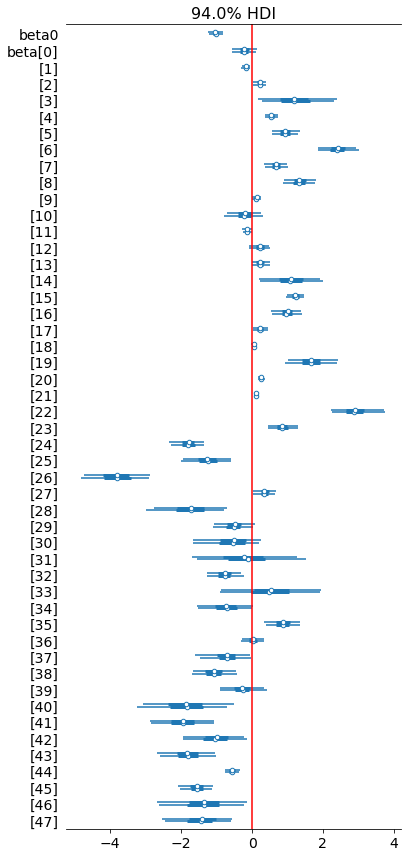

In [36]:
pm.forestplot(all_trace, var_names = ['beta0', 'beta'])
plt.axvline(x=0, color="red") #to determine whether the feature is statistically significant 

### Model 2: Just Words
Assume the distribution for all words is Gaussian with mean 0, and a large SD to account for variation --> UNINFORMED PRIOR

In [37]:
col_names = data_uci_freq.columns
alpha_colnames = [x for x in col_names if x.isalpha() and x != 'spamlabel']

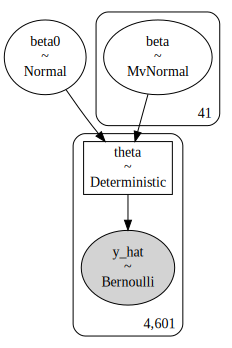

In [38]:
X = data_uci_freq[alpha_colnames]
y = data_uci_freq['spamlabel']
num_pred = len(X.columns)
with Model() as model_alpha:
    beta0 = pm.Normal('beta0', 0, sd = 1)
    beta = pm.MvNormal('beta', mu = np.zeros(num_pred), cov = np.identity(num_pred), shape = num_pred)
    
    mu = pm.invlogit(beta0 + pm.math.dot(X, beta))
    theta = pm.Deterministic('theta', mu)
    
    y_hat = pm.Bernoulli('y_hat', p = theta, observed = y)
pm.model_to_graphviz(model_alpha)

In [39]:
with model_alpha:
    alpha_trace = pm.sample(draws = 1000, cores = 4, chains = 2, tune = 1000)
    alpha_idata = az.from_pymc3(alpha_trace)
az.summary(alpha_idata, round_to = 2, var_names = ["beta0", "beta"])

<ipython-input-39-90cc25de45d9>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  alpha_trace = pm.sample(draws = 1000, cores = 4, chains = 2, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 196 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.90,0.10,-1.09,-0.72,0.00,0.00,1711.56,950.51,1.0
beta[0],-0.14,0.17,-0.46,0.17,0.00,0.00,1672.22,1401.20,1.0
beta[1],-0.19,0.07,-0.32,-0.08,0.00,0.00,2168.65,1242.48,1.0
beta[2],0.21,0.10,0.02,0.39,0.00,0.00,1947.18,1437.92,1.0
beta[3],0.54,0.09,0.36,0.71,0.00,0.00,1795.38,1364.56,1.0
beta[4],1.10,0.22,0.69,1.50,0.00,0.00,2222.43,1280.85,1.0
beta[5],2.49,0.31,1.92,3.04,0.01,0.00,2227.44,1285.11,1.0
beta[6],0.94,0.18,0.58,1.27,0.00,0.00,2177.86,1270.73,1.0
beta[7],1.35,0.24,0.87,1.79,0.00,0.00,2640.04,1644.30,1.0
beta[8],0.13,0.07,-0.01,0.26,0.00,0.00,2414.26,1324.37,1.0


In [40]:
with model_alpha:
    waic_alpha = az.waic(alpha_trace)
waic_alpha

C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 4601 log-likelihood matrix

          Estimate       SE
elpd_waic -1193.03    45.36
p_waic       59.50        -

There has been a warning during the calculation. Please check the results.

<ipython-input-41-4b58e5d5bd8f>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(alpha_trace, var_names = ['beta0', 'beta'])
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

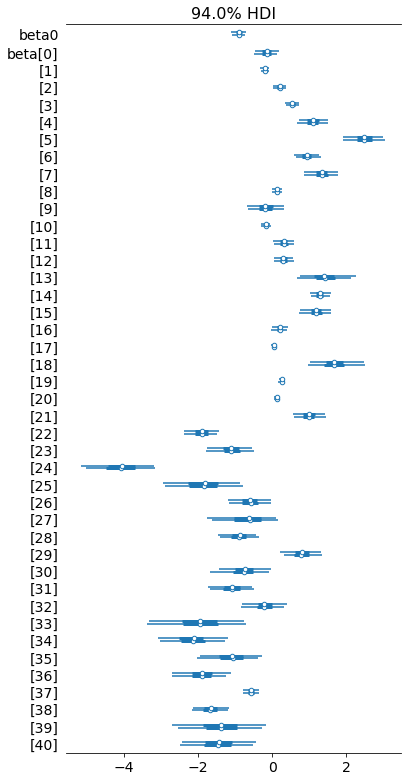

In [41]:
pm.forestplot(alpha_trace, var_names = ['beta0', 'beta'])

### Model 3: Only significant from Model 1
From Model 1: insignificant words are: [0, 2, 9, 10, 11, 12, 13, 17, 18, 27, 29, 30, 31, 33, 34, 36, 39]

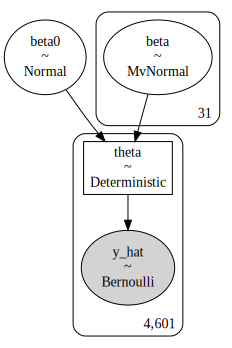

In [42]:
insig_cols = [0, 2, 9, 10, 11, 12, 13, 17, 18, 27, 29, 30, 31, 33, 34, 36, 39, 48]

X = data_uci_freq.drop(data_uci.columns[insig_cols], axis = 1)
y = data_uci_freq['spamlabel']
num_pred = len(X.columns)
with Model() as model_reduced:
    beta0 = pm.Normal('beta0', 0, sd = 1)
    beta = pm.MvNormal('beta', mu = np.zeros(num_pred), cov = np.identity(num_pred), shape = num_pred)
    
    mu = pm.invlogit(beta0 + pm.math.dot(X, beta))
    theta = pm.Deterministic('theta', mu)
    
    y_hat = pm.Bernoulli('y_hat', p = theta, observed = y)
pm.model_to_graphviz(model_reduced)

In [43]:
with model_reduced:
    reduced_trace = pm.sample(draws = 1000, cores = 4, chains = 2, tune = 1000)
    reduced_idata = az.from_pymc3(reduced_trace)
az.summary(reduced_idata, round_to = 2, var_names = ["beta0", "beta"])

<ipython-input-43-9273132a3d0d>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  reduced_trace = pm.sample(draws = 1000, cores = 4, chains = 2, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 151 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.89,0.09,-1.05,-0.73,0.00,0.00,2321.74,1687.04,1.0
beta[0],-0.16,0.06,-0.26,-0.07,0.00,0.00,3313.22,1315.92,1.0
beta[1],1.25,0.61,0.17,2.34,0.01,0.01,2216.27,1040.41,1.0
beta[2],0.54,0.10,0.37,0.72,0.00,0.00,3474.16,1189.22,1.0
beta[3],0.94,0.21,0.54,1.32,0.00,0.00,3053.55,1392.63,1.0
beta[4],2.50,0.30,1.97,3.09,0.01,0.00,3602.00,1578.65,1.0
beta[5],0.67,0.16,0.36,0.96,0.00,0.00,3429.84,1582.67,1.0
beta[6],1.31,0.24,0.86,1.75,0.00,0.00,2828.33,1247.10,1.0
beta[7],1.39,0.45,0.61,2.27,0.01,0.01,2865.62,1270.03,1.0
beta[8],1.28,0.14,0.99,1.52,0.00,0.00,2565.24,1581.88,1.0


In [44]:
with model_reduced:
    waic_reduced = az.waic(reduced_trace)
waic_reduced

C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 4601 log-likelihood matrix

          Estimate       SE
elpd_waic -1131.64    43.39
p_waic       43.64        -

There has been a warning during the calculation. Please check the results.

<ipython-input-45-d43f8f5f26f9>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(reduced_trace, var_names = ['beta0', 'beta'])
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

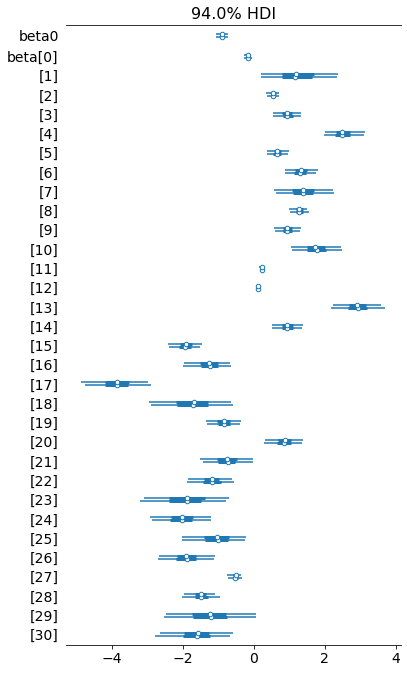

In [45]:
pm.forestplot(reduced_trace, var_names = ['beta0', 'beta'])

In [46]:
comparing_spam = az.compare({'Full Model': all_trace,
            'Reduced Model Alpha': alpha_trace,
            'Reduced Model Insig': reduced_trace},
          ic='WAIC', method='BB-pseudo-BMA', scale='deviance')
comparing_spam

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\anash\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Full Model,0,2258.404438,61.100804,0.000000,6.418649e-01,82.957424,0.000000,True,deviance
Reduced Model Insig,1,2263.273785,43.643177,4.869347,3.581351e-01,87.179087,14.823621,True,deviance
Reduced Model Alpha,2,2386.054604,59.501232,127.650166,8.034553e-14,83.457447,22.904762,True,deviance


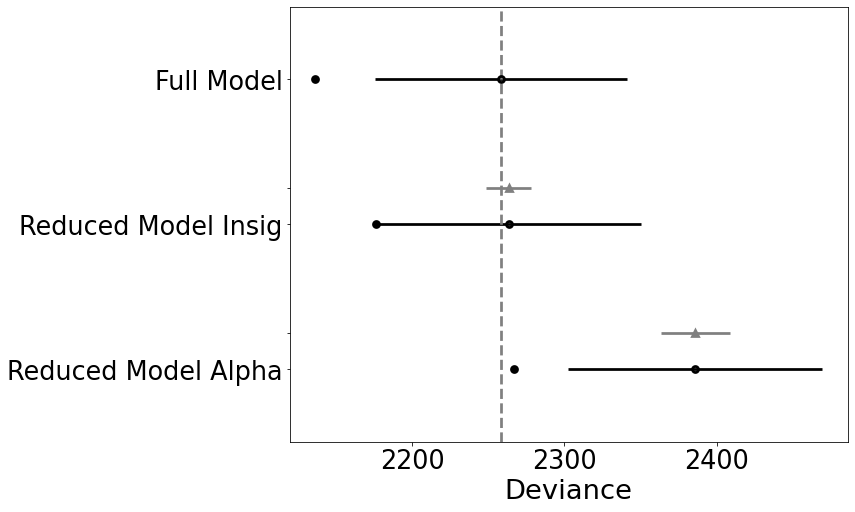

In [47]:
az.plot_compare(comparing_spam, figsize = (10,8));

### Sample posterior predictions for each model

In [48]:
fullmodel_pred = pm.sample_posterior_predictive_w(traces=[all_trace], samples = 1000, models=[all_model])

reducedalpha_pred = pm.sample_posterior_predictive_w(traces=[alpha_trace], samples = 1000, models=[model_alpha])

reducedinsig_pred = pm.sample_posterior_predictive_w(traces=[reduced_trace], samples = 1000, models=[model_reduced])

#Posterior predictions from Bayesian Model Averaging
bma_prediction = pm.sample_posterior_predictive_w(traces=[all_trace, alpha_trace, reduced_trace], 
                                                  samples=1000,
                                                  models =[all_model, model_alpha, model_reduced],
                                                  weights=comparing_spam['weight'])

In [49]:
yhat_df = pd.DataFrame()
yhat_df['fullmodel_yhat'] = pd.DataFrame(np.row_stack(next(iter(fullmodel_pred.items()))[1])).mean(0)
yhat_df['reducedalpha_yhat'] = pd.DataFrame(np.row_stack(next(iter(reducedalpha_pred.items()))[1])).mean(0)
yhat_df['reducedinsig_yhat'] = pd.DataFrame(np.row_stack(next(iter(reducedinsig_pred.items()))[1])).mean(0)
yhat_df['BMA_yhat'] = pd.DataFrame(np.row_stack(next(iter(bma_prediction.items()))[1])).mean(0)
yhat_df['yhat'] = uci_spam_labels
yhat_df

,fullmodel_yhat,reducedalpha_yhat,reducedinsig_yhat,BMA_yhat,yhat
0,0.524,0.543,0.457,0.552,1
1,0.938,0.870,0.920,0.907,1
2,1.000,0.988,1.000,1.000,1
3,0.833,0.862,0.840,0.864,1
4,0.809,0.852,0.838,0.864,1
...,...,...,...,...,...
4596,0.106,0.102,0.140,0.103,0
4597,0.040,0.044,0.032,0.036,0
4598,0.078,0.061,0.066,0.057,0
4599,0.135,0.133,0.169,0.143,0


In [50]:
spam_yhat = yhat_df[yhat_df.yhat == 1]
ham_yhat = yhat_df[yhat_df.yhat == 0]

Text(0.5, 1.0, 'Posterior Predictions for Spam model')

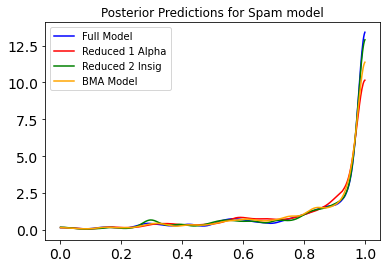

In [51]:
fig, ax = plt.subplots()
az.plot_kde(np.array(spam_yhat.fullmodel_yhat), plot_kwargs={'color':'blue', 'label':'Full Model'}, ax=ax)
az.plot_kde(np.array(spam_yhat.reducedalpha_yhat), plot_kwargs={'color':'red', 'label':'Reduced 1 Alpha'}, ax=ax)
az.plot_kde(np.array(spam_yhat.reducedinsig_yhat), plot_kwargs={'color':'green', 'label':'Reduced 2 Insig'}, ax=ax)
az.plot_kde(np.array(spam_yhat.BMA_yhat), plot_kwargs={'color':'orange', 'label':'BMA Model'}, ax=ax)
plt.title('Posterior Predictions for Spam model')

[Text(0.5, 0, 'Spam Posterior')]

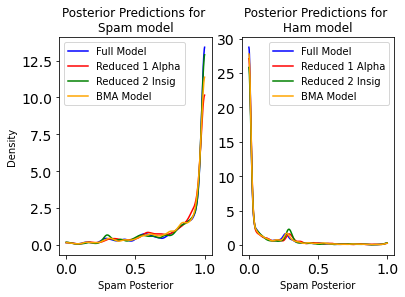

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2)
# plt.figure(figsize=(20,20))

az.plot_kde(np.array(spam_yhat.fullmodel_yhat), plot_kwargs={'color':'blue', 'label':'Full Model'}, ax=ax1)
az.plot_kde(np.array(spam_yhat.reducedalpha_yhat), plot_kwargs={'color':'red', 'label':'Reduced 1 Alpha'}, ax=ax1)
az.plot_kde(np.array(spam_yhat.reducedinsig_yhat), plot_kwargs={'color':'green', 'label':'Reduced 2 Insig'},ax=ax1)
az.plot_kde(np.array(spam_yhat.BMA_yhat), plot_kwargs={'color':'orange', 'label':'BMA Model'},ax=ax1)
ax1.set_title('Posterior Predictions for \nSpam model')
ax1.set(xlabel='Spam Posterior', ylabel = 'Density')


az.plot_kde(np.array(ham_yhat.fullmodel_yhat), plot_kwargs={'color':'blue', 'label':'Full Model'}, ax=ax2)
az.plot_kde(np.array(ham_yhat.reducedalpha_yhat), plot_kwargs={'color':'red', 'label':'Reduced 1 Alpha'}, ax=ax2)
az.plot_kde(np.array(ham_yhat.reducedinsig_yhat), plot_kwargs={'color':'green', 'label':'Reduced 2 Insig'}, ax=ax2)
az.plot_kde(np.array(ham_yhat.BMA_yhat), plot_kwargs={'color':'orange', 'label':'BMA Model'}, ax=ax2)
ax2.set_title('Posterior Predictions for \nHam model')
ax2.set(xlabel='Spam Posterior')
